In [1]:
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from neuralhydrology.evaluation.metrics import calculate_all_metrics

/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:242: SyntaxWarning: invalid escape sequence '\d'
  weekly_freq = re.match('(\d+)W(-(MON|TUE|WED|THU|FRI|SAT|SUN))?$', native_frequency)


In [2]:
def clean_df(df):
    #clean columns/rows
    df.columns = df.iloc[0]
    df = df[3:]
    df.columns = df.columns.str.strip()
    df = df.drop(columns=['Ordinate'])
    df = df.rename(columns={'Date': 'Day', 'Time': 'Time'})
    
    # Increment the date by 1 day where Time is '24:00:00' and replace '24:00:00' with '00:00:00'
    mask = df['Time'] == '24:00:00'
    df.loc[mask, 'Day'] = (pd.to_datetime(df.loc[mask, 'Day'], format='%d-%b-%y') + pd.Timedelta(days=1)).dt.strftime('%d-%b-%y')
    df['Time'] = df['Time'].replace('24:00:00', '00:00:00')

    # Combine 'Day' and 'Time' columns to create a new 'date' column, make sure duplicated columns are dropped
    df['date'] = pd.to_datetime(df['Day'], format='%d-%b-%y') + pd.to_timedelta(df['Time'])
    df.dropna(subset=['date'], inplace=True)
    df = df.loc[:, ~df.columns.duplicated(keep=False)]
    df.set_index('date', inplace=True)

    # Drop 'Day' and 'Time' columns
    df.drop(columns=['Day', 'Time'], inplace=True)
    return df

In [7]:
lstmPhysicsHourly_results = '/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/warm_springs_all/runs/testing_run_3001_113144/results_output_validation.csv'
lstmHourly_results = '/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/warm_springs_all/runs/testing_run_3001_112958/results_output_validation.csv'
hms_results = '/Users/mia/research/UCB-USACE-LSTMs/data/updated_russian_river_folder/WarmSprings_Inflow_hourly.csv'

In [75]:
def combinedPlot(lstm_results: Path, lstmPhysics_results: Path, HMS_results: Path, title: str, fName = "metrics.csv"):
    
    lstm_df = pd.read_csv(lstm_results).rename(columns={'Predicted': 'LSTM_Predicted'}) #columns: Date, Observed, Predicted --> LSTM_Predicted
    lstm_df['Date'] = pd.to_datetime(lstm_df['Date'])
    lstm_df.loc[lstm_df['LSTM_Predicted'] < 0, 'LSTM_Predicted'] = 0
    
    physics_lstm_df = pd.read_csv(lstmPhysics_results).rename(columns={'Predicted': 'PLSTM_Predicted'}) #columns: Date, Observed, Predicted --> PLSTM_Predicted
    physics_lstm_df['Date'] = pd.to_datetime(physics_lstm_df['Date'])
    physics_lstm_df.drop(columns=['Observed'], inplace=True)
    physics_lstm_df.loc[physics_lstm_df['PLSTM_Predicted'] < 0, 'PLSTM_Predicted'] = 0
    
    hms_df = pd.read_csv(HMS_results) #columns: Date, HMS_predicted
    cleaned_hms_df = clean_df(hms_df)
    # Rename the first column to 'hms_results'
    cleaned_hms_df.rename(columns={cleaned_hms_df.columns[0]: 'HMS_Predicted'}, inplace=True)

    # Add a 'Date' column containing the index values
    cleaned_hms_df = cleaned_hms_df.reset_index().rename(columns={'date': 'Date'})
    cleaned_hms_df = cleaned_hms_df[['Date', 'HMS_Predicted']]

    # Merge the LSTM, PLSTM and HMS DataFrames on the 'Date' column
    df = lstm_df.merge(cleaned_hms_df, how='right', on='Date').merge(physics_lstm_df, how='right', on='Date')

    # Ensure that the columns contain only numeric values
    df['Observed'] = pd.to_numeric(df['Observed'], errors='coerce')
    df['HMS_Predicted'] = pd.to_numeric(df['HMS_Predicted'], errors='coerce')
    df['LSTM_Predicted'] = pd.to_numeric(df['LSTM_Predicted'], errors='coerce')
    df['PLSTM_Predicted'] = pd.to_numeric(df['PLSTM_Predicted'], errors='coerce')
    
    #Convert pandas Series to xarray DataArray with a datetime coordinate
    obs_da = xr.DataArray(df['Observed'].values, dims=["date"], coords={"date": df['Date']})
    sim_da_hms = xr.DataArray(df['HMS_Predicted'].values, dims=["date"], coords={"date": df['Date']})
    sim_da_lstm = xr.DataArray(df['LSTM_Predicted'].values, dims=["date"], coords={"date": df['Date']})
    sim_da_plstm = xr.DataArray(df['PLSTM_Predicted'].values, dims=["date"], coords={"date": df['Date']})

    # Collect metrics into a dictionary
    metrics = {
        "HMS": calculate_all_metrics(obs_da, sim_da_hms),
        "LSTM": calculate_all_metrics(obs_da, sim_da_lstm),
        "Physics_Informed_LSTM": calculate_all_metrics(obs_da, sim_da_plstm),
    }

    metrics_df = pd.DataFrame(metrics)
    output_csv_path = fName
    metrics_df.to_csv(output_csv_path)

    # Plot all columns against the "date_col" (x-axis)
    plt.figure(figsize=(30, 10))
    
    plt.plot(df["Date"], df["Observed"], label='Observed', linewidth=2)
    plt.plot(df["Date"], df["HMS_Predicted"], label='HMS Prediction',  linewidth=2, alpha=0.7)
    #plt.plot(df["Date"], df["LSTM_Predicted"], label='LSTM Prediction', linewidth=2, alpha=0.8)
    #plt.plot(df["Date"], df["PLSTM_Predicted"], label='Physics Informed LSTM Prediction', linewidth=2, alpha=0.7)
    
    # Customize the plot
    plt.tick_params(axis='x', labelsize=15)  # For x-axis tick labels
    plt.tick_params(axis='y', labelsize=15) 
    plt.xlabel("Date", fontsize=20)
    plt.ylabel("Inflow (cubic feet per second)", fontsize=20)
    plt.title(title, fontsize=30)
    plt.legend(fontsize=25, loc="upper right")
    plt.grid(True, alpha=0.4)

     # Set x-axis limits to the extent of the observed data
    plt.xlim(df['Date'].min(), df['Date'].max())

    plt.tight_layout()
    plt.show()

    #print(metrics)
    return plt, metrics_df

/var/folders/37/ck6mkvd952v7g_qhcgs0fbrh0000gq/T/ipykernel_28890/2475738968.py:12: DtypeWarning: Columns (0,3,4,5,6,7,8,9,10,11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  hms_df = pd.read_csv(HMS_results) #columns: Date, HMS_predicted
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/dat

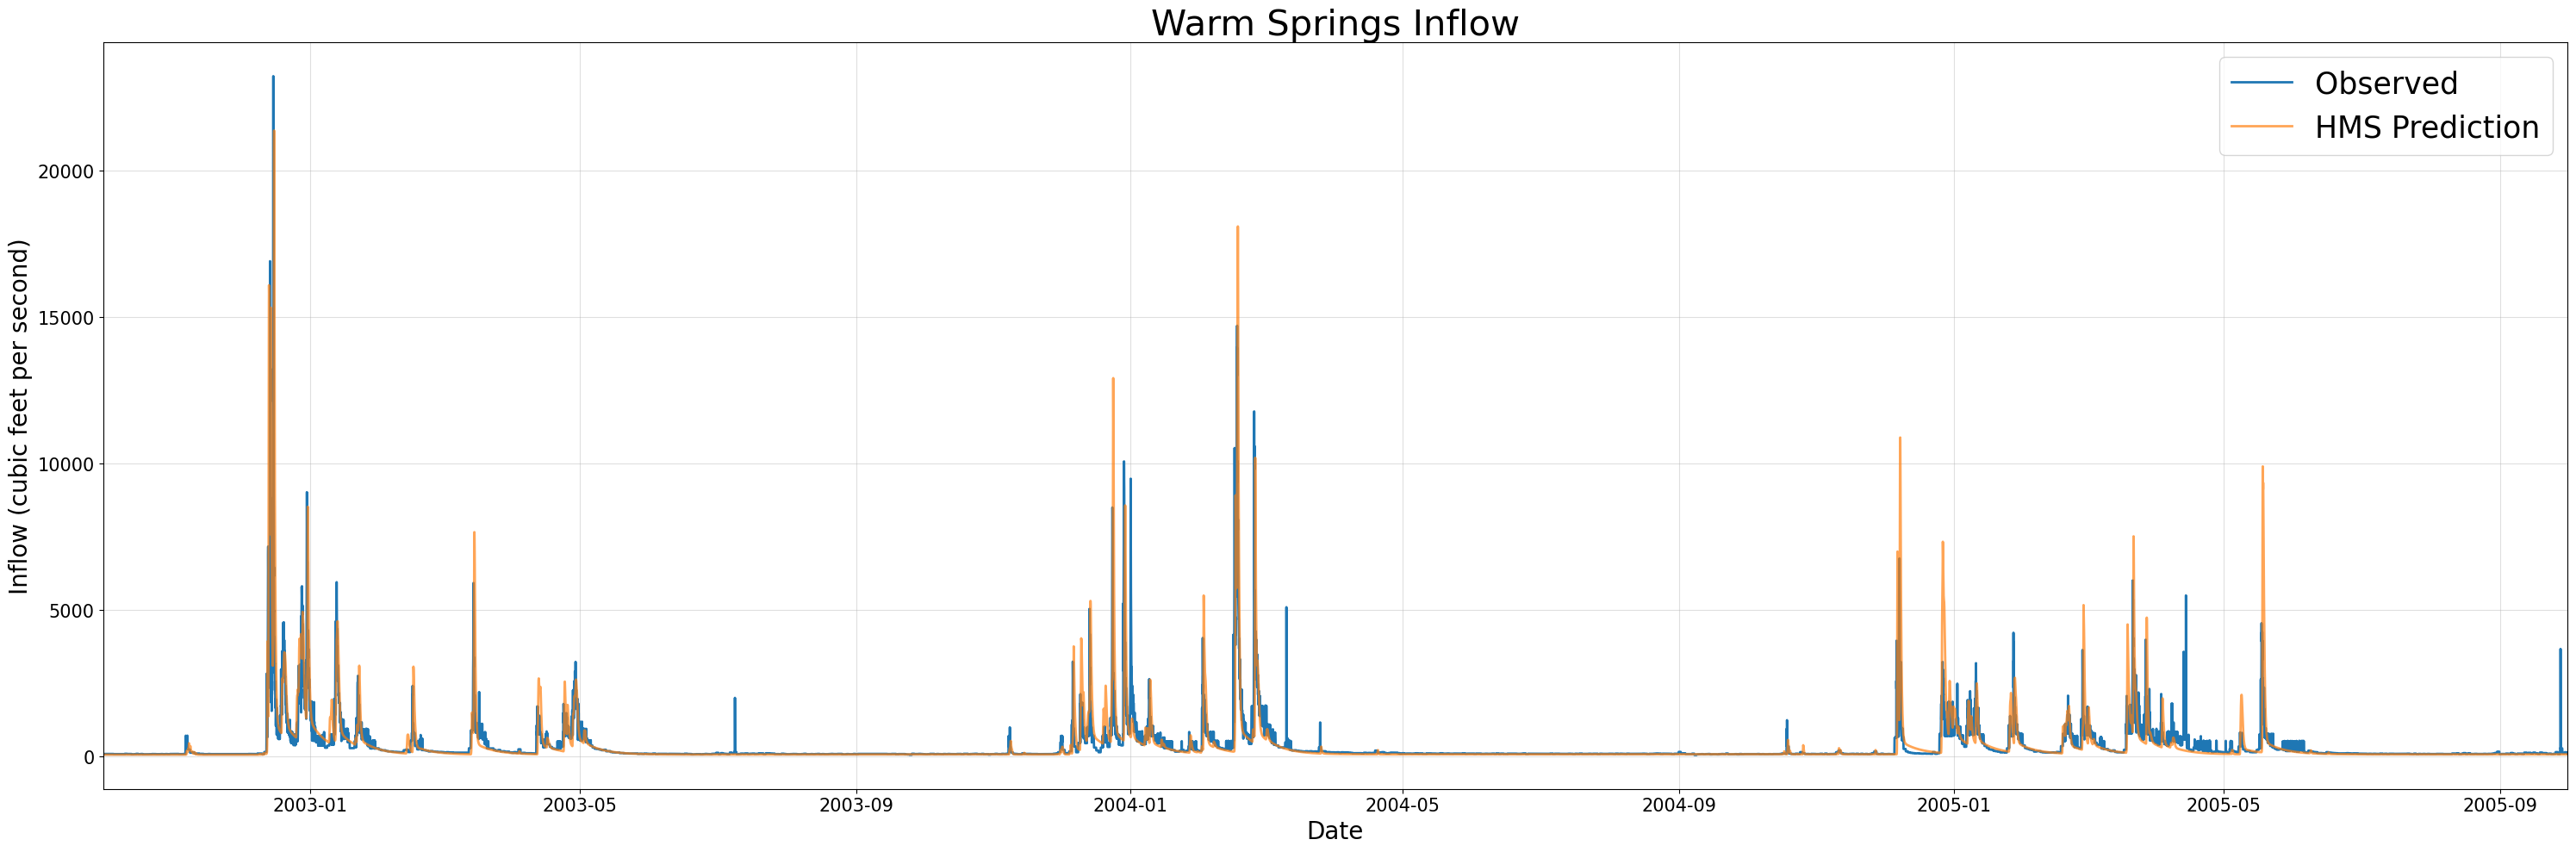

(<module 'matplotlib.pyplot' from '/Users/mia/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>,
                        HMS           LSTM  Physics_Informed_LSTM
 NSE               0.006826       0.586038               0.540634
 MSE          630255.178815  262695.128533          291507.699516
 RMSE            793.886125     512.537929             539.914530
 KGE               0.526288       0.677510               0.659658
 Alpha-NSE         1.322813       0.802710               0.822252
 Beta-KGE          1.087251       1.105066               1.132273
 Beta-NSE          0.035655       0.042936               0.054054
 Pearson-r         0.664467       0.767540               0.741655
 FHV              35.450486     -11.586234             -14.596300
 FMS              12.396291     -45.950297             -22.816504
 FLV              75.850873   -2756.560972           -2736.552702
 Peak-Timing            NaN            NaN                    NaN
 Peak-MAPE        76.359717      

In [76]:
combinedPlot(lstmHourly_results, lstmPhysicsHourly_results, hms_results, "Warm Springs Inflow")

check daily as well:

In [77]:
lstmDaily_results = '/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/warm_springs_all/runs/testing_run_3001_112827/results_output_validation.csv'
lstmPhysicsDaily_results = '/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/warm_springs_all/runs/testing_run_3001_113026/results_output_validation.csv'
hms_results_daily_path = '/Users/mia/research/UCB-USACE-LSTMs/data/updated_russian_river_folder/WarmSprings_Inflow_daily.csv'

/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
/Users/mia/research/UCB-USACE-LSTMs/neuralhydrology/datautils/utils.py:339: FutureWarning:

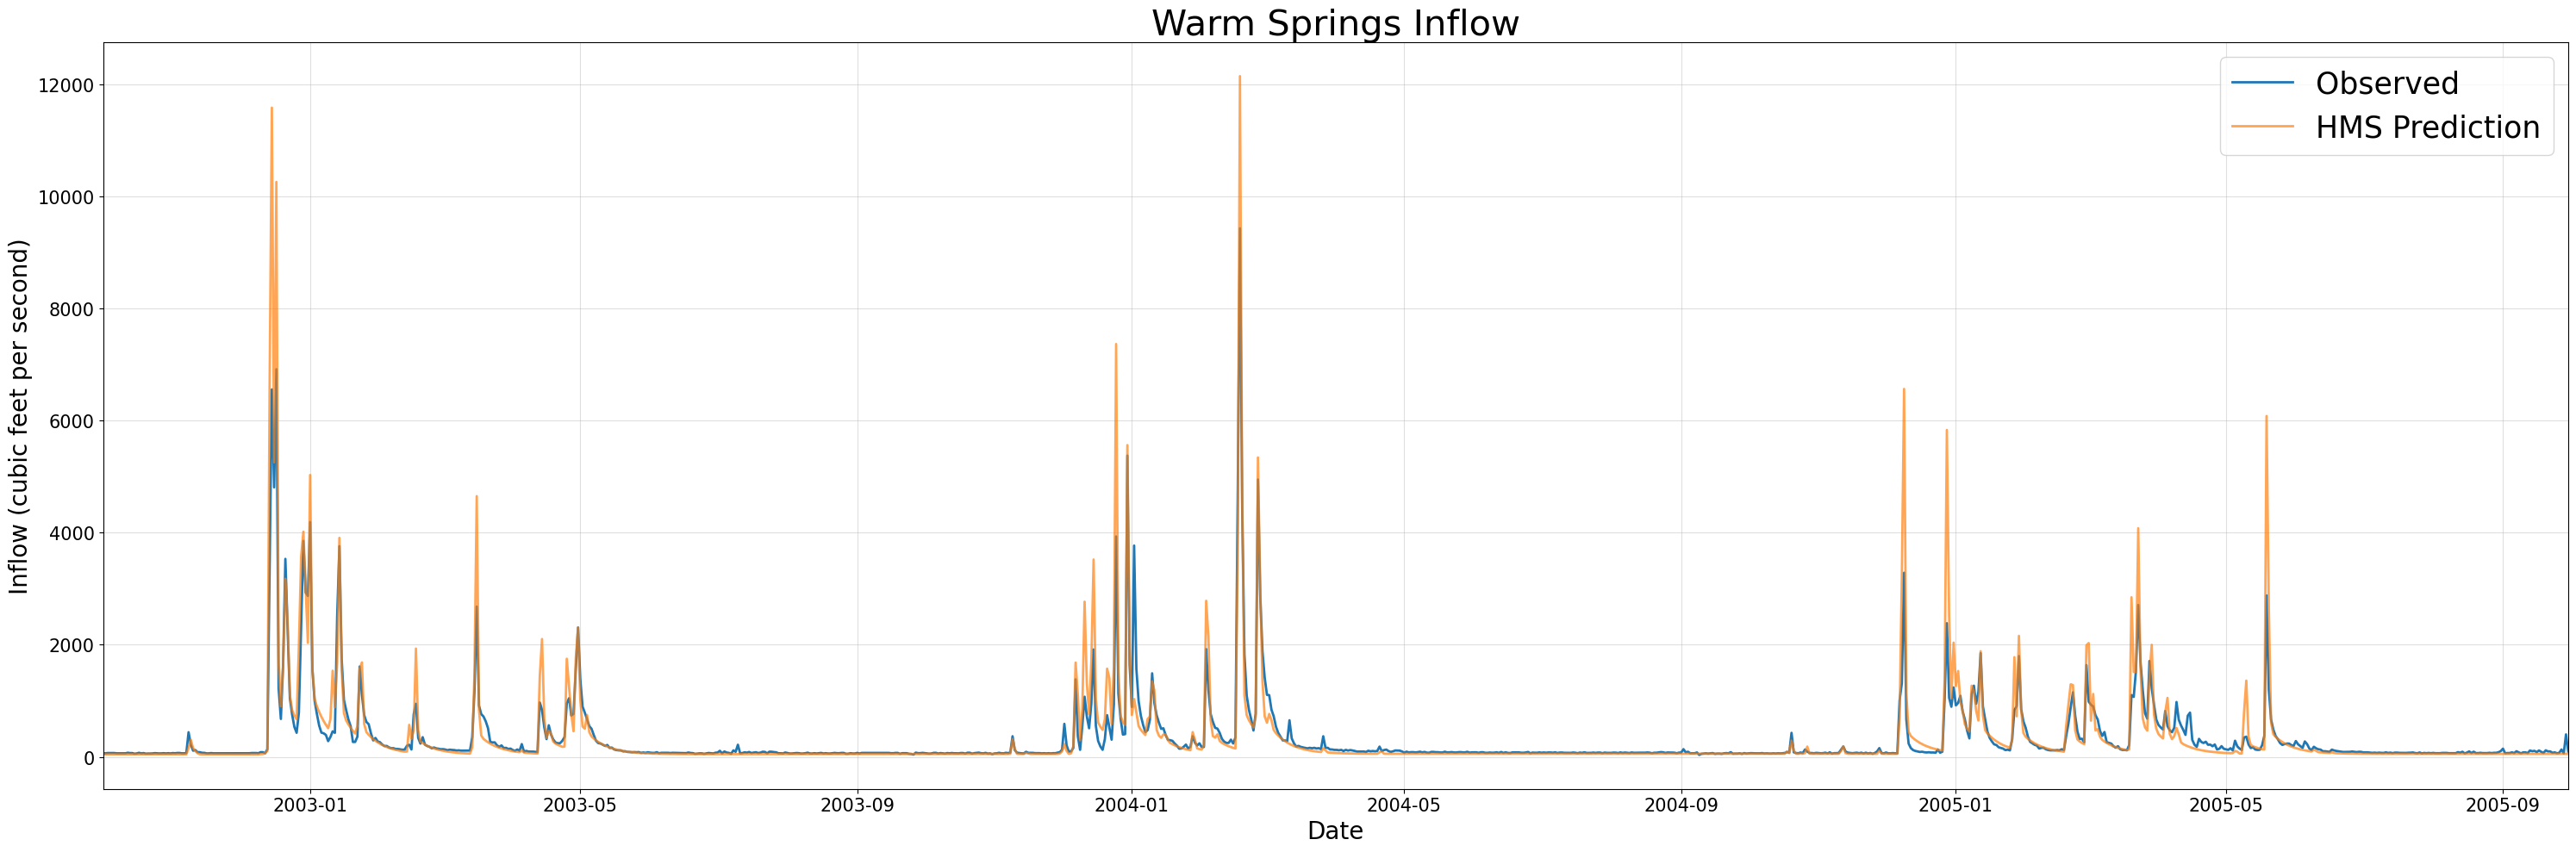

(<module 'matplotlib.pyplot' from '/Users/mia/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>,
                        HMS          LSTM  Physics_Informed_LSTM
 NSE               0.695977      0.803620               0.768265
 MSE          149067.929476  96288.988851          113623.862440
 RMSE            386.093162    310.304671             337.081388
 KGE               0.629017      0.881153               0.700524
 Alpha-NSE         1.354590      0.940231               1.183229
 Beta-KGE          1.087426      0.993658               1.223254
 Beta-NSE          0.040637     -0.002948               0.103773
 Pearson-r         0.934800      0.897472               0.920813
 FHV              34.412169     -5.154520              15.781553
 FMS              11.222054    -40.586953             115.685076
 FLV              75.923474  -2233.852551            -946.889651
 Peak-Timing       0.000000      0.400000               0.000000
 Peak-MAPE        57.593945     33.229447     

In [78]:
combinedPlot(lstmDaily_results, lstmPhysicsDaily_results, hms_results_daily_path, "Warm Springs Inflow")